#### Name: Mohammad Koodun

# PREDICTING AIRLINE CUSTOMER BUYING BEHAVIOUR

## Problem Formulation:

Airlines face intense competition in attracting customers for flights and holiday packages, and the modern buying cycle means that decisions are often made well before travelers arrive at the airport. To remain competitive, airlines must predict customer purchase behavior early in the decision process.

The objective of this task is to develop a predictive model to determine the likelihood that a customer will complete a booking for a holiday.

The success of this project will be measured by the model’s ability to correctly identify customers likely to book holidays, while providing actionable insights for targeted marketing and customer acquisition strategies.


## Data Preparation & Feature Engineering:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.under_sampling import RandomUnderSampler

The dataset, sourced from the British Airways Data Science Job Simulation, contains 50,000 records with 14 attributes describing customer booking information. Each feature is defined as follows:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking



In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


Several features are stored as `object` data types and need to be converted into numerical form for modeling. For the `flight_day` column, which contains the days of the week, it is logical to map them to numeric values from 1 to 7, corresponding to Monday through Sunday.

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

The target variable in the dataset is `booking_complete`, represented as a binary flag (1 for completed bookings, 0 otherwise).

In [ ]:
# Define target and features
target = df['booking_complete']
features = df.drop(columns=['booking_complete'])

In [9]:
categorical_cols = features.select_dtypes(include=["object"]).columns
print(categorical_cols)

Index(['sales_channel', 'trip_type', 'route', 'booking_origin'], dtype='object')


In [10]:
def find_unique(name):
    return df[name].unique()

for cat in categorical_cols:
    print(f"\n{cat} unique values:")
    print(find_unique(cat))


sales_channel unique values:
['Internet' 'Mobile']

trip_type unique values:
['RoundTrip' 'CircleTrip' 'OneWay']

route unique values:
['AKLDEL' 'AKLHGH' 'AKLHND' 'AKLICN' 'AKLKIX' 'AKLKTM' 'AKLKUL' 'AKLMRU'
 'AKLPEK' 'AKLPVG' 'AKLTPE' 'AORICN' 'AORKIX' 'AORKTM' 'AORMEL' 'BBIMEL'
 'BBIOOL' 'BBIPER' 'BBISYD' 'BDOCTS' 'BDOCTU' 'BDOHGH' 'BDOICN' 'BDOIKA'
 'BDOKIX' 'BDOMEL' 'BDOOOL' 'BDOPEK' 'BDOPER' 'BDOPUS' 'BDOPVG' 'BDOSYD'
 'BDOTPE' 'BDOXIY' 'BKICKG' 'BKICTS' 'BKICTU' 'BKIHND' 'BKIICN' 'BKIKIX'
 'BKIKTM' 'BKIMEL' 'BKIMRU' 'BKIOOL' 'BKIPEK' 'BKIPER' 'BKIPUS' 'BKIPVG'
 'BKISYD' 'BKIXIY' 'BLRICN' 'BLRMEL' 'BLRPER' 'BLRSYD' 'BOMMEL' 'BOMOOL'
 'BOMPER' 'BOMSYD' 'BTJJED' 'BTUICN' 'BTUPER' 'BTUSYD' 'BTUWUH' 'BWNCKG'
 'BWNDEL' 'BWNHGH' 'BWNIKA' 'BWNKTM' 'BWNMEL' 'BWNOOL' 'BWNPER' 'BWNSYD'
 'BWNTPE' 'CANDEL' 'CANIKA' 'CANMEL' 'CANMRU' 'CANOOL' 'CANPER' 'CANSYD'
 'CCUMEL' 'CCUMRU' 'CCUOOL' 'CCUPER' 'CCUSYD' 'CCUTPE' 'CEBMEL' 'CEBOOL'
 'CEBPER' 'CEBSYD' 'CGKCKG' 'CGKCTS' 'CGKCTU' 'CGKDEL' 'CGKHG

Features with high cardinality, namely `booking_origin` and `route`, were excluded from model training to reduce complexity and avoid overfitting. The remaining categorical features with low cardinality, `sales_channel` and `trip_type`, were transformed into numerical form through encoding.

In [11]:
df['sales_channel_encoded'] = LabelEncoder().fit_transform(df['sales_channel'])
df['trip_type_encoded'] = LabelEncoder().fit_transform(df['trip_type'])

features = df.drop(columns=['booking_complete', 'booking_origin', 'route', 'sales_channel', 'trip_type'])

The features were standardised using `StandardScaler` to ensure uniform scaling across variables. Principal Component Analysis (PCA) was applied to assess feature importance, with the cumulative explained variance plot indicating that all 11 features collectively account for 100% of the variance.

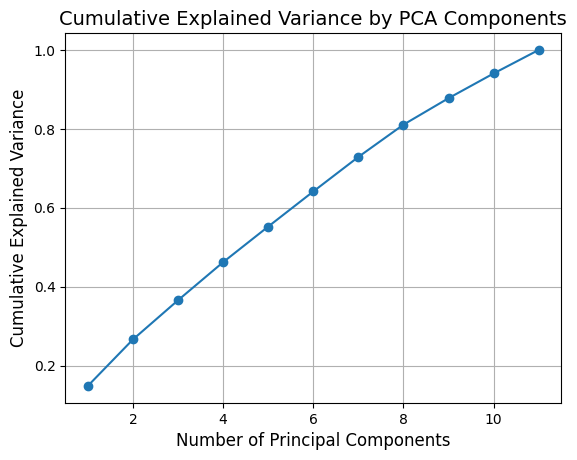

In [26]:
# Standardise the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Fit PCA
pca = PCA(random_state=10)
pca.fit(features_scaled, target)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot
plt.figure()
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.title('Cumulative Explained Variance by PCA Components', fontsize=14)
plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)

plt.grid(True)
plt.show()


Given the class imbalance in the target variable, undersampling was performed to adjust the dataset so that the minority class, completed bookings, was set to half the size of the majority class.

In [40]:
# Define undersampler (target 50-50 balance)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_res, y_res = rus.fit_resample(features_scaled, target)

## Model Selection & Training:

A random forest classifier was selected because it effectively handles mixed data types, which suits our dataset containing both numeric and categorical features. Additionally, it is robust to outliers and capable of modeling non-linear relationships.

The model was trained mostly with default settings, except for the `class_weight` parameter, which was set to `balanced` to address the class imbalance. The dataset was split into 70% for training and 30% for testing, using stratification to maintain the original class distribution.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.3, random_state=10)

In [43]:
model = RandomForestClassifier(class_weight='balanced', random_state=10)

model.fit(Xtrain, ytrain)

RandomForestClassifier(class_weight='balanced', random_state=10)

In [44]:
# Make predictions
ypred = model.predict(Xtest)

# Evaluate model
results = [{
    'Model': 'RandomForest Classifier',
    'Accuracy': round(accuracy_score(ytest, ypred), 3),
    'Precision': round(precision_score(ytest, ypred), 3),
    'Recall': round(recall_score(ytest, ypred), 3),
}]

results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall
0,RandomForest Classifier,0.682,0.55,0.301


The initial model showed moderate to low performance in terms of accuracy, precision, and recall. To check for potential overfitting, the model’s performance on the training set will also be evaluated and compared with the test set results.

## Model Evaulation

To ensure a robust evaluation of model performance, Stratified Cross-Validation was employed. This technique measures how well a model generalises to unseen data by dividing the dataset into multiple folds, training on subsets of the data, and validating on the remaining fold. The process is repeated for all folds, and the results are averaged to provide a more reliable performance estimate.

Stratified Cross-Validation scores were calculated for accuracy, precision, and recall. Additionally, a confusion matrix and a Receiver Operating Characteristic (ROC) curve were generated to further assess the model’s performance.

In [45]:
# Defining the cross-validation strategy
cv = StratifiedKFold(shuffle=True, random_state=10, n_splits=5)

In [46]:
# Perform cross-validation using the trained model and prints the metrics
def cv_metrics(model, features, target, title, cv):
    # Evaluation metrics
    scoring = ['accuracy', 'precision', 'recall']
    # Perform cross-validation
    scores = cross_validate(model, features, target, cv=cv, scoring=scoring, return_train_score=True, n_jobs=-1)

    # Prints the header
    print(f"\nCross-validation results for the {title} model:\n")
    # Loops through each metric and prints the mean and std 
    for metric in scoring:
        print(f"- Train {metric.capitalize()}: {scores[f'train_{metric}'].mean():.3f} ± {scores[f'train_{metric}'].std():.3f}")
        print(f"- Test  {metric.capitalize()}: {scores[f'test_{metric}'].mean():.3f} ± {scores[f'test_{metric}'].std():.3f}")
    print("\n")
    return
    
def cv_pred(model, features, target, cv, label_names=None, title='Model'):
    # Generate cross-validation predictions (class labels)
    ypred = cross_val_predict(model, features, target, cv=cv, n_jobs=-1)

    # Generate cross-validation predicted probabilities (for ROC)
    yproba = cross_val_predict(model, features, target, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

    # Confusion matrix
    cm = confusion_matrix(target, ypred, labels=model.classes_)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names or model.classes_)
    disp.plot(cmap='viridis', ax=ax, values_format='d')
    plt.title(f'Confusion Matrix (Cross-Val) - {title}', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(target, yproba)
    auc_score = roc_auc_score(target, yproba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print confusion matrix summary
    tn, fp, fn, tp = cm.ravel()
    print(f"""
Summary for {title} model:
- Predicted Positives: {np.sum(ypred):,}
- True Negatives: {tn:,}
- True Positives: {tp:,}
- False Negatives: {fn:,}
- False Positives: {fp:,}
- ROC AUC Score: {auc_score:.3f}
""")


Cross-validation results for the RandomForest model:

- Train Accuracy: 1.000 ± 0.000
- Test  Accuracy: 0.682 ± 0.003
- Train Precision: 0.999 ± 0.000
- Test  Precision: 0.539 ± 0.008
- Train Recall: 1.000 ± 0.000
- Test  Recall: 0.290 ± 0.010




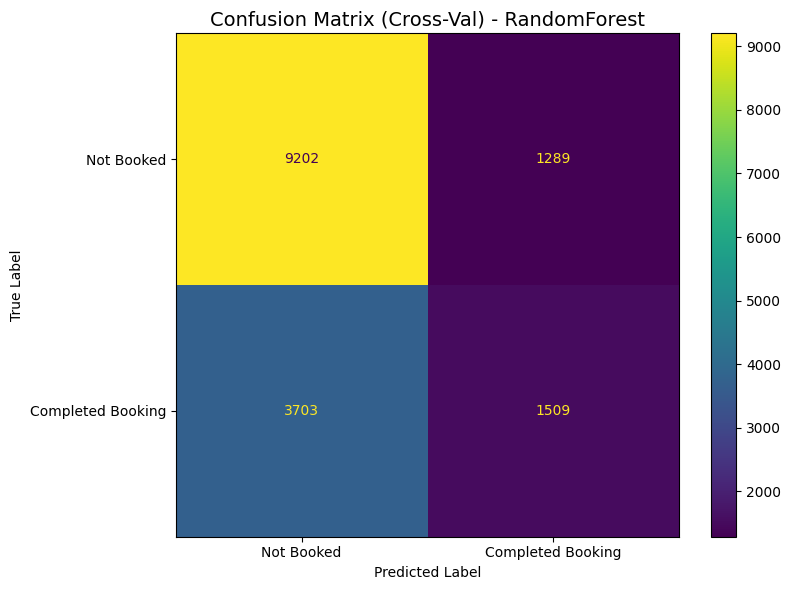

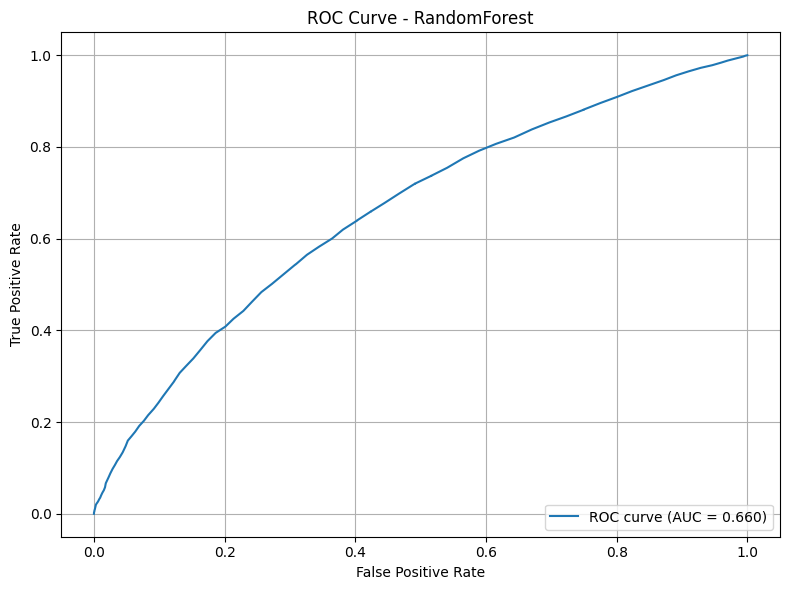


Summary for RandomForest model:
- Predicted Positives: 2,798
- True Negatives: 9,202
- True Positives: 1,509
- False Negatives: 3,703
- False Positives: 1,289
- ROC AUC Score: 0.660



In [48]:
# call functions
cv_metrics(model, Xtrain, ytrain, 'RandomForest', cv)
cv_pred(model, Xtrain, ytrain, cv=cv, label_names=['Not Booked', 'Completed Booking'], title='RandomForest')

Overall, the model’s performance was suboptimal, exhibiting signs of overfitting and a low recall score of 0.290. The ROC curve also reflected moderate performance, with an AUC of 0.660.

## Model Tuning

Given the limited performance of the default model, improvements could be achieved through model tuning. To gain a deeper understanding of the model’s learning behavior, learning curves were generated. These curves plot performance on both the training and validation sets against the size of the training dataset, helping to diagnose issues such as underfitting, overfitting, or insufficient data. They also provide insight into whether the model might benefit from additional training examples or increased complexity.

In [50]:
# Function to plot learning curves and print metric scores 
def plot_learning_curve(model, features, target, cv, title1, scorings=['precision', 'recall'], train_sizes=np.linspace(0.2, 1.0, 4)):
    # Set up the figure
    fig, axes = plt.subplots(len(scorings), 1, figsize=(8, 4 * len(scorings)))
    all_metrics = "" # define an empty string to use later

    # Loops for the 2 scorings
    for i, score in enumerate(scorings):
        train_sizes_out, train_scores, test_scores = learning_curve(
            estimator=model,
            X=features,
            y=target,
            cv=cv,
            scoring=score,
            train_sizes=train_sizes,
            n_jobs=-1
        )

        # Calculate means and stds
        train_mean = train_scores.mean(axis=1)
        test_mean = test_scores.mean(axis=1)
        train_std = train_scores.std(axis=1)
        test_std = test_scores.std(axis=1)

        # Metrics summary
        all_metrics += (
            f'\n- {score.capitalize()}:\n'
            f'  - Train: {train_mean.mean():.3f} ± {train_std.mean():.3f}\n'
            f'  - Test : {test_mean.mean():.3f} ± {test_std.mean():.3f}\n'
        )

        # Plotting
        ax = axes[i] if len(scorings) > 1 else axes
        ax.plot(train_sizes_out, train_mean, label='Training Score', lw=2)
        ax.plot(train_sizes_out, test_mean, label='Validation Score', lw=2)
        ax.fill_between(train_sizes_out, train_mean - train_std, train_mean + train_std, alpha=0.2)
        ax.fill_between(train_sizes_out, test_mean - test_std, test_mean + test_std, alpha=0.2)
        # labelling
        ax.set_title(f'Learning Curve – {score.capitalize()}', fontsize=12)
        ax.set_xlabel('Training Size')
        ax.set_ylabel(f'{score.capitalize()} Score')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f'Learning Curves for {title1}', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print(f"Average CV Scores for {title1}:\n{all_metrics}")

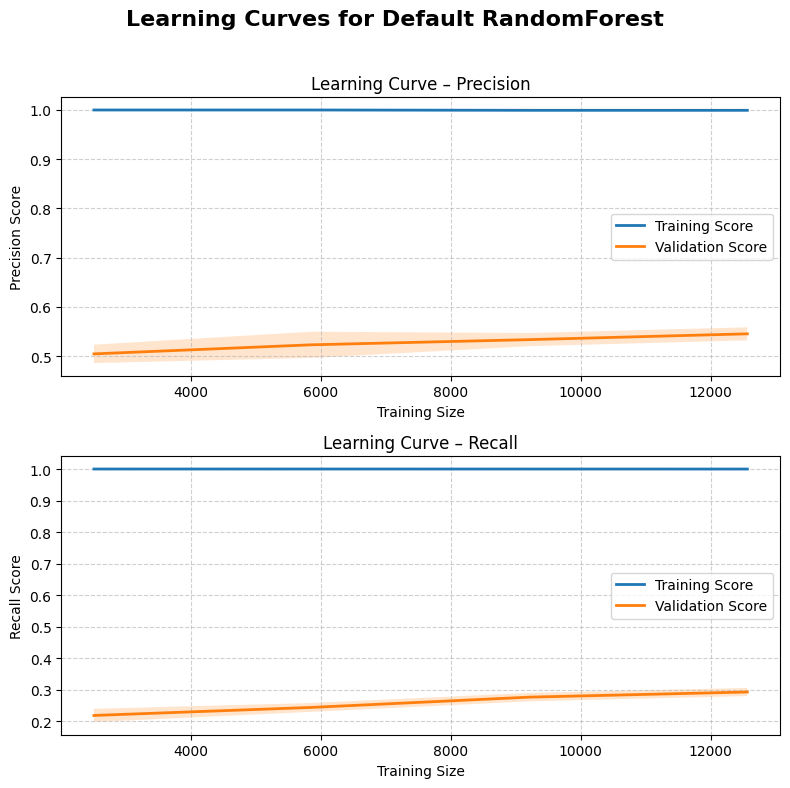

Average CV Scores for Default RandomForest:

- Precision:
  - Train: 1.000 ± 0.000
  - Test : 0.527 ± 0.018

- Recall:
  - Train: 1.000 ± 0.000
  - Test : 0.257 ± 0.015



In [51]:
# Calling function
plot_learning_curve(model, Xtrain, ytrain, cv, title1='Default RandomForest')

The learning curves further confirm the presence of overfitting. To address this, a grid search was  conducted on the model’s hyperparameters in an effort to reduce overfitting and improve overall performance.

In [52]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [53]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',   # focus on recall
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(Xtrain, ytrain)
# Best parameters & model
print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Evaluation
y_pred = best_rf.predict(Xtest)
print(classification_report(ytest, y_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\Raees\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4465
           1       0.49      0.57      0.53      2266

    accuracy                           0.66      6731
   macro avg       0.63      0.64      0.63      6731
weighted avg       0.67      0.66      0.66      6731



Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


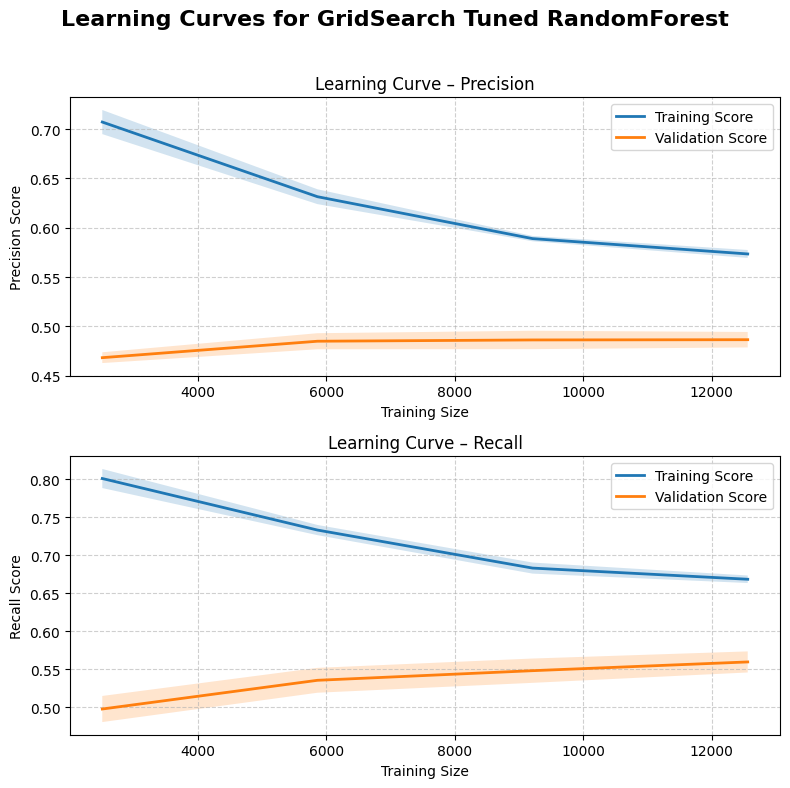

Average CV Scores for GridSearch Tuned RandomForest:

- Precision:
  - Train: 0.625 ± 0.007
  - Test : 0.481 ± 0.008

- Recall:
  - Train: 0.722 ± 0.008
  - Test : 0.535 ± 0.016



In [54]:
plot_learning_curve(grid_search.best_estimator_, Xtrain, ytrain, cv, title1='GridSearch Tuned RandomForest')

The model no longer exhibited overfitting, and test performance improved, with the recall score increasing to 0.535. The learning curves also indicated that training and test scores were converging as the training set size grew. The test precision stabilised around 0.50, while the recall appeared capable of reaching approximately 0.60 if additional data were available.

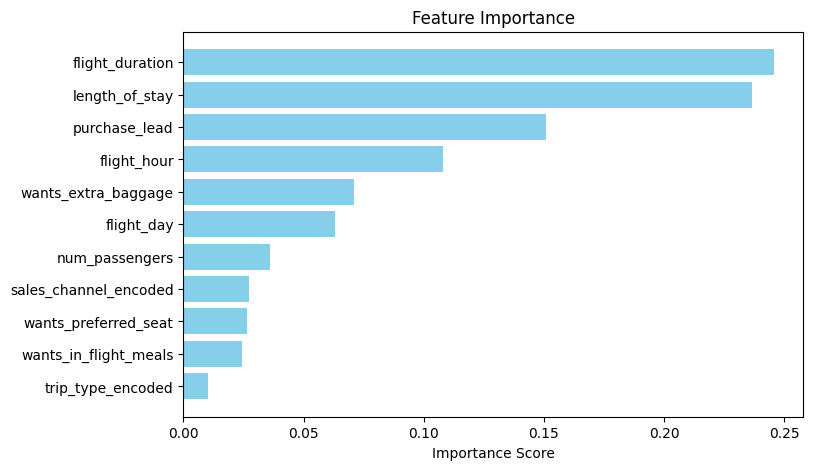

In [57]:
importances = grid_search.best_estimator_.feature_importances_
feature_names = features.columns

# Create DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,5))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest at the top
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.show()

## Conclusion:

The model’s performance on the current dataset was limited, with low test scores indicating that it struggles to make accurate predictions. This suggests that the dataset may benefit from additional customer-centric features that better capture the factors influencing the target outcome. Among the variables considered, flight duration emerged as the most important predictor in the model.

Future efforts could explore alternative ensemble methods or other algorithms, such as gradient boosting or logistic regression, which might better handle class imbalance and improve predictive performance. While undersampling was used in this analysis, other techniques, such as oversampling, Synthetic Minority Over-sampling Technique, or a hybrid approach could help balance the classes without discarding valuable information. Finally, increasing the size of the training dataset and experimenting with more hyperparameter optimisation could further improve generalisation and recall, particularly for minority classes.